Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## **Importing Libraries**

In [54]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models  # type: ignore
from tensorflow.keras.models import Sequential  # type: ignore

import warnings
warnings.filterwarnings("ignore")

### **Data Reading**

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [30]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


###**Create a Dataset**

In [31]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [32]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [33]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [34]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [35]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


###**Data Visualisation**

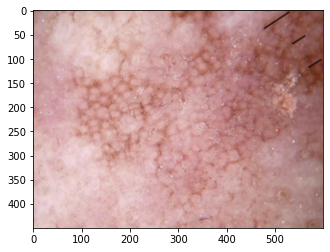

In [36]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

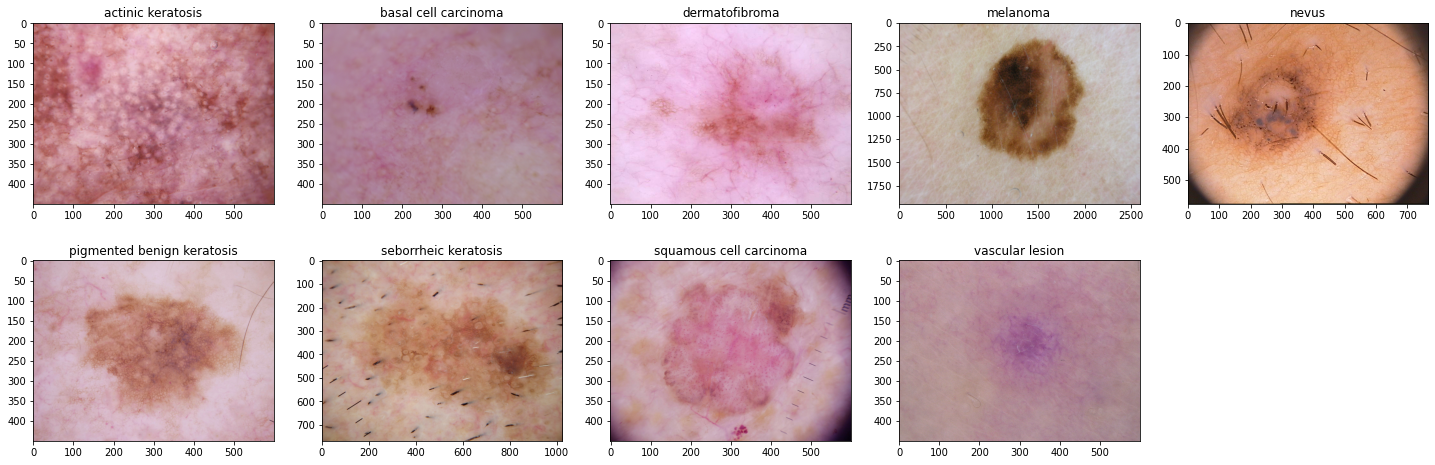

In [37]:

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [38]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### **Model Building and Training**

*   Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).





In [55]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [56]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

In [57]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 690s 6s/step - loss: 3.6196 - accuracy: 0.1730 - val_loss: 2.1024 - val_accuracy: 0.2036
Epoch 2/20
56/56 [==============================] - 234s 4s/step - loss: 1.8276 - accuracy: 0.3331 - val_loss: 1.6110 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 239s 4s/step - loss: 1.5402 - accuracy: 0.4548 - val_loss: 1.4879 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 236s 4s/step - loss: 1.4283 - accuracy: 0.5006 - val_loss: 1.4593 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 252s 5s/step - loss: 1.3262 - accuracy: 0.5318 - val_loss: 1.5478 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 214s 4s/step - loss: 1.2503 - accuracy: 0.5519 - val_loss: 1.5305 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 214s 4s/step - loss: 1.1313 - accuracy: 0.6044 - val_loss: 1.5558 - val_accuracy: 0.4989
Epoch 8/20
56

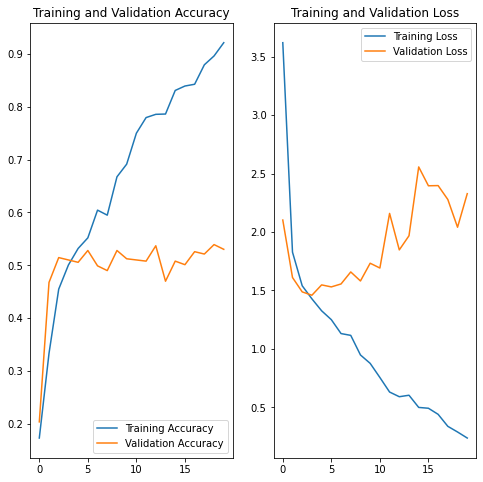

In [58]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings:**

1. The training accuracy rises linearly with time, whereas the validation accuracy peaks at 53% accuracy during the training phase.
2. The validation loss rises as the training loss decreases throughout the course of epochs.
3. Plots reveal significant discrepancies between training and validation accuracy, with the model achieving about 53% accuracy on the validation set.
4. Overfitting is evident when there is a noticeable difference in accuracy between training and validation





### **Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [59]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

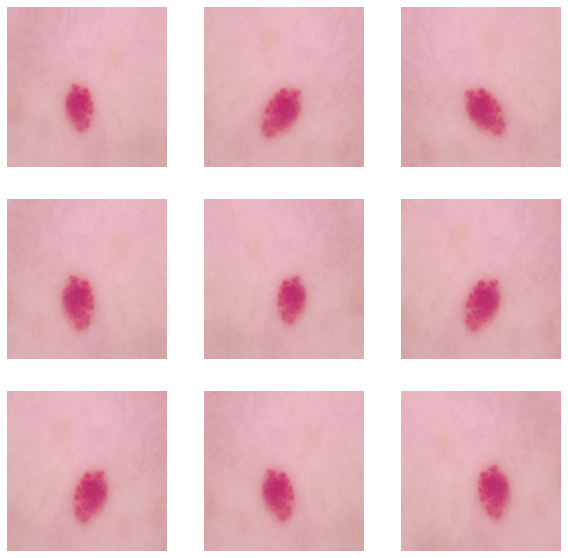

In [60]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Model Building & training on the augmented data :**

In [61]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [62]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [63]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 226s 4s/step - loss: 3.0543 - accuracy: 0.2712 - val_loss: 1.8373 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 227s 4s/step - loss: 1.7203 - accuracy: 0.3772 - val_loss: 1.6416 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 226s 4s/step - loss: 1.5725 - accuracy: 0.4581 - val_loss: 1.4942 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 224s 4s/step - loss: 1.4319 - accuracy: 0.4967 - val_loss: 1.8023 - val_accuracy: 0.3848
Epoch 5/20
56/56 [==============================] - 223s 4s/step - loss: 1.4566 - accuracy: 0.5011 - val_loss: 1.4142 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 223s 4s/step - loss: 1.3673 - accuracy: 0.5212 - val_loss: 1.4607 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 223s 4s/step - loss: 1.3200 - accuracy: 0.5379 - val_loss: 1.3764 - val_accuracy: 0.5414
Epoch 8/20
56

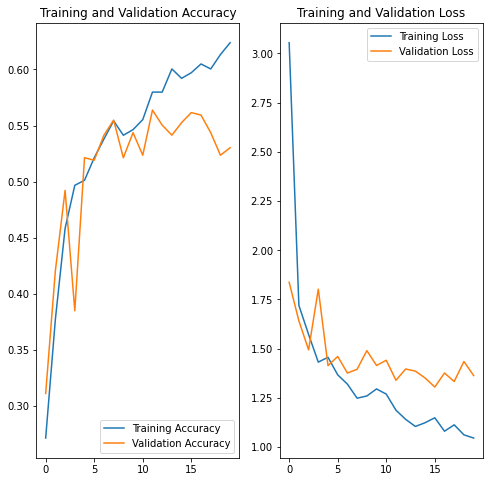

In [64]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings :**

1. As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 53% accuracy in training process.
2. As the training loss decreases with epochs the validation loss decreases and stalls.
3. The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 53% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.

### **Model Building & training on the augmented data with dropout :**

In [65]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [66]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [67]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 232s 4s/step - loss: 3.7583 - accuracy: 0.2282 - val_loss: 1.8786 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 227s 4s/step - loss: 1.8422 - accuracy: 0.3616 - val_loss: 1.7403 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 227s 4s/step - loss: 1.6266 - accuracy: 0.4208 - val_loss: 1.5981 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 227s 4s/step - loss: 1.5639 - accuracy: 0.4637 - val_loss: 1.6427 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 227s 4s/step - loss: 1.5553 - accuracy: 0.4621 - val_loss: 1.4363 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 226s 4s/step - loss: 1.4469 - accuracy: 0.4944 - val_loss: 1.4554 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 226s 4s/step - loss: 1.3719 - accuracy: 0.5229 - val_loss: 1.4143 - val_accuracy: 0.5302
Epoch 8/20
56

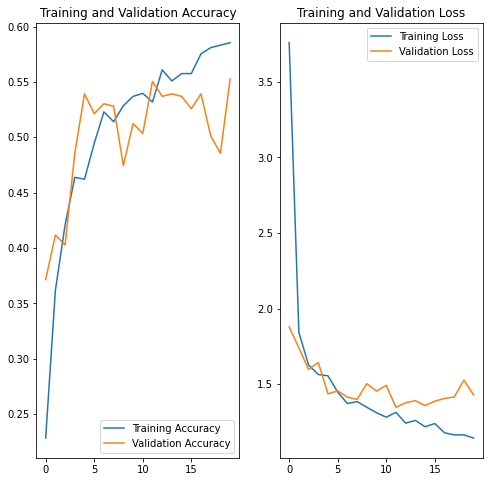

In [68]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings**:

1. As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
2. As the training loss decreases with epochs the validation loss decreases
3. The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is very less

**We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

### **Class distribution:**

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

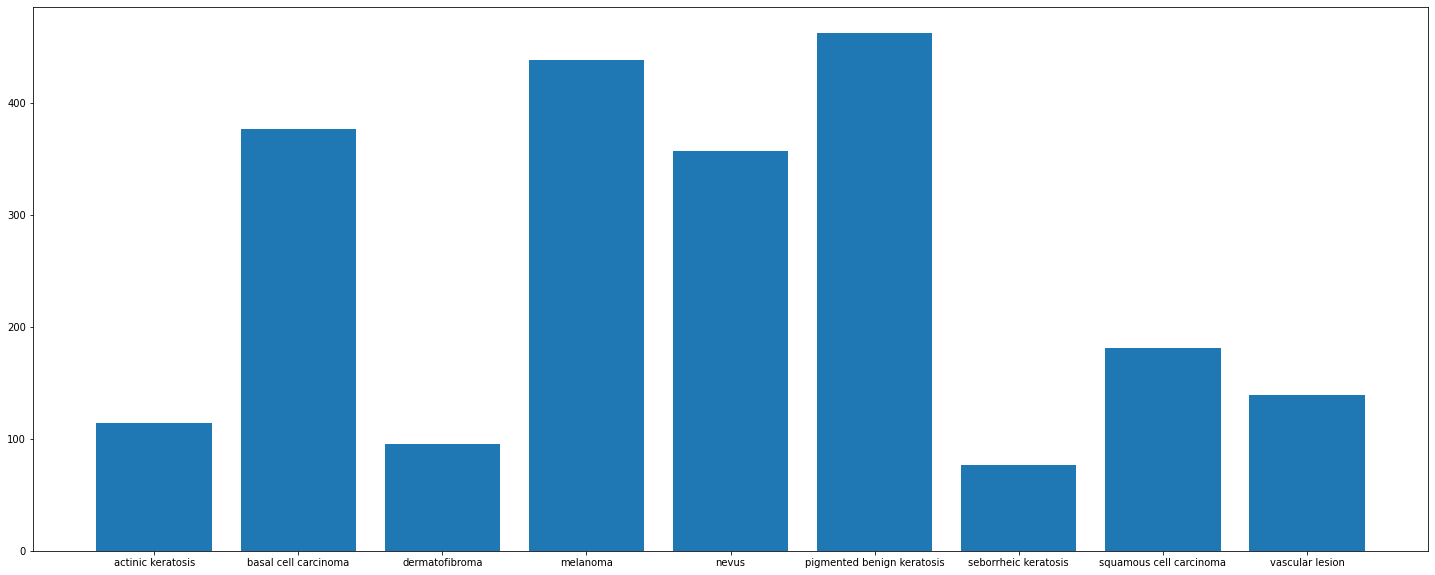

In [86]:
count = []
for i in class_names:
  count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [69]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


**Findings :**
1. Which class has the least number of samples?
**seborrheic keratosis with 77 samples**
2. Which classes dominate the data in terms proportionate number of samples?
**pigmented benign keratosis with 462 samples**

### **Handling class imbalances:**

In [73]:
!pip install Augmentor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset,save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFED6739430>: 100%|██████████| 500/500 [00:50<00:00,  9.97 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=965x624 at 0x7EFED64D3B80>: 100%|██████████| 500/500 [00:56<00:00,  8.81 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1016x682 at 0x7EFED65DC1F0>: 100%|██████████| 500/500 [00:54<00:00,  9.09 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFED65B42B0>: 100%|██████████| 500/500 [00:51<00:00,  9.72 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EFED6849EE0>: 100%|██████████| 500/500 [00:46<00:00, 10.64 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFED553F9A0>: 100%|██████████| 500/500 [00:59<00:00,  8.46 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFED66AAD60>: 100%|██████████| 500/500 [00:44<00:00, 11.31 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFED660FCD0>: 100%|██████████| 500/500 [00:57<00:00,  8.63 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFED818FE50>: 100%|██████████| 500/500 [00:50<00:00,  9.81 Samples/s]


In [88]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


In [89]:
#Lets see the distribution of augmented data after adding new images to the original training data.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [90]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [91]:
df['Label'].value_counts()

pigmented benign keratosis    938
melanoma                      897
basal cell carcinoma          734
nevus                         722
squamous cell carcinoma       361
vascular lesion               294
actinic keratosis             217
dermatofibroma                182
seborrheic keratosis          155
Name: Label, dtype: int64

In [92]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [93]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [94]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


### **Model Building & training on the rectified class imbalance data :**

In [95]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [96]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [97]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 [==============================] - 481s 4s/step - loss: 2.1771 - accuracy: 0.3369 - val_loss: 1.5208 - val_accuracy: 0.5022
Epoch 2/30
113/113 [==============================] - 475s 4s/step - loss: 1.4802 - accuracy: 0.4878 - val_loss: 1.4017 - val_accuracy: 0.5044
Epoch 3/30
113/113 [==============================] - 504s 4s/step - loss: 1.3662 - accuracy: 0.5164 - val_loss: 1.3157 - val_accuracy: 0.5578
Epoch 4/30
113/113 [==============================] - 467s 4s/step - loss: 1.3103 - accuracy: 0.5333 - val_loss: 1.2780 - val_accuracy: 0.5667
Epoch 5/30
113/113 [==============================] - 469s 4s/step - loss: 1.2922 - accuracy: 0.5361 - val_loss: 1.2947 - val_accuracy: 0.5533
Epoch 6/30
113/113 [==============================] - 466s 4s/step - loss: 1.2157 - accuracy: 0.5614 - val_loss: 1.1836 - val_accuracy: 0.5822
Epoch 7/30
113/113 [==============================] - 470s 4s/step - loss: 1.1893 - accuracy: 0.5719 - val_loss: 1.1817 - val_accuracy: 0.5733

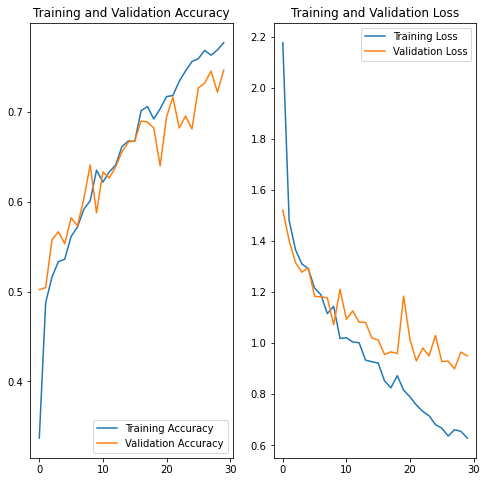

In [98]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

**Findings :**
1. As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
2. As the training loss decreases with epochs the validation loss also decreases.
3. The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 
4. 75% accuracy on the validation set.
The difference in accuracy between training and validation accuracy is very less

**Class rebalancing not only got rid of overfitting it also improved the validation accuracy from 53% to 75%.**